# Vector data

TO BE SUPPLIED


## Manipulating Features with Fiona and Shapely
Here we use Fiona 
to read Vector data (Features) into memory for subsequent Shapely manipulation.

Feature geometry can be accessed using the `geometry` property of each feature, for example
we can open the dataset that contains a (Multi)Polygon for each country and print
out the geometry of the 10th Feature:

First we import `Shapely` and its functions and then convert the JSON-encoded geometries to Geometry objects
using the `shape` function.

This is Canada


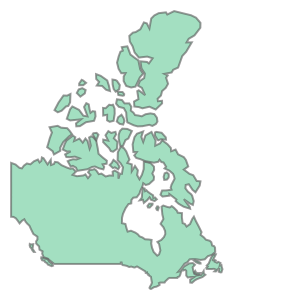

In [1]:
import fiona
from shapely.geometry import shape

with fiona.open("../data/countries.3857.gpkg") as countries:
	country = countries[4]
	print("This is %s" % country["properties"]["NAME"])
	geom = shape(country["geometry"])
  
geom # Jupyter can display geometry data directly

In [2]:
print(geom.type)

MultiPolygon


In [3]:
print(geom.area)

52166480440472.38


In [4]:
# In km
print(geom.length/1000)

143193.97061044376


Let's have a look at some geometry methods. 
Tip: Shapely code is well-documented, you can always use the Python built-in `help()` function.

In [ ]:
help(geom)

For example we can make a buffer of 500 meter around our polygon (making Canada somewhat bigger):

In [ ]:
buffered_geom = geom.buffer(500)
buffered_geom

In [ ]:
# In km
buffered_geom.length/1000

### Converting the geometry back to JSON format
Once we are finished, we can convert the geometry back to JSON format using `shapely.geometry.mapping` function


In [ ]:
from shapely.geometry import mapping

In [ ]:
# let's create new GeoJSON-encoded vector feature

new_feature = {
	"type": "Feature",
	"properties": {"name": "My buffered feature"},
	"geometry": mapping(buffered_geom)
}
new_feature

# Now we could e.g. write the Feature back to file


---
[<- Projections](03-projections.ipynb) | [Raster data ->](05-raster-data.ipynb)
